# Text Classification: Language Anxiety

## Importing Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D

from tensorflow.keras.optimizers import AdamW
from sklearn.utils import shuffle

import keras

from sklearn.utils import class_weight
from sklearn.metrics import f1_score

import random

In [ ]:
# Set random seed for reproducibility
seed = 2045
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Reading The Dataset

In [ ]:
df = pd.read_excel('/content/Clean_Merged_Anxiety_Dataset_Updated AI Label.xlsx')
df = df[df['is_ai_generated_label'] == 0]
df = df[["Post", "LA Class"]]

# Pisahkan kelas anxiety
# df_anxiety = df[df["LA Class"] == "Anxiety"]
# df_no_anxiety = df[df["LA Class"] == "No Anxiety"]

# Sampling data anxiety supaya jadi sekitar 60 baris
# df_anxiety_sampled = df_anxiety.sample(n=150, random_state=42)  # Random sampling 60 baris

# Gabungkan kembali data yang sudah disampling
# df = pd.concat([df_anxiety_sampled, df_no_anxiety], ignore_index=True)

df.head()

,Post,LA Class
1,The innovation of technology has transformed a...,Anxiety
3,Lack of sexual education in children in Indone...,No Anxiety
4,Imagine no longer needing to be stuck in traff...,Anxiety
5,Eco-friendly is a way of living without harmin...,Anxiety
6,"With the Increasing focus on Generative Al, 20...",No Anxiety


## Checking Class Distribution

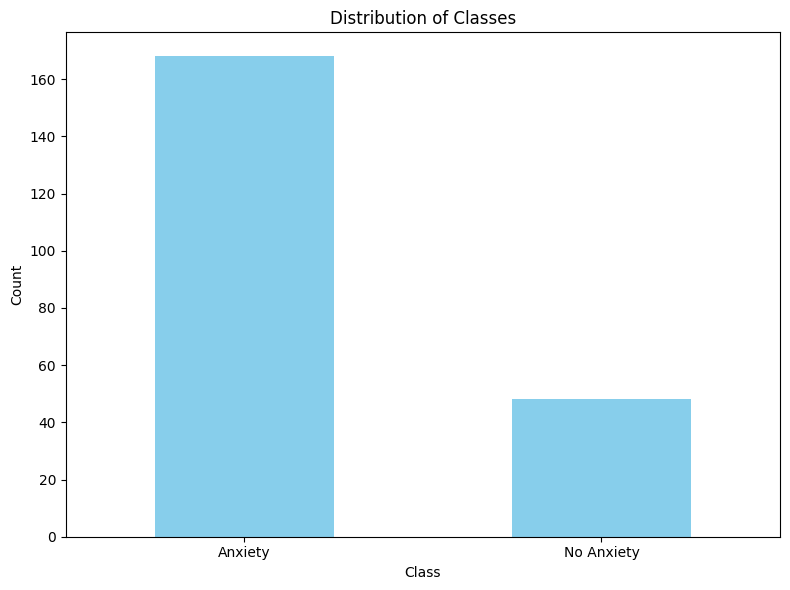

In [ ]:
# Mengambil nilai perhitungan distribusi kelas
class_counts = df['LA Class'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Untuk memutar label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

In [ ]:
df['LA Class'].value_counts()

,count
LA Class,
Anxiety,168
No Anxiety,48


## Encode Target Variable

In [ ]:
# Menggunakan mapping manual dengan map
df['la_class'] = df['LA Class'].map({'Anxiety': 1, 'No Anxiety': 0})

# Menampilkan hasil
print("Mapping kelas ke nilai encoded:")
print(df[['LA Class', 'la_class']])

# Menghapus kolom asli
df.drop(columns=['LA Class'], inplace=True)

Mapping kelas ke nilai encoded:
       LA Class  la_class
1       Anxiety         1
3    No Anxiety         0
4       Anxiety         1
5       Anxiety         1
6    No Anxiety         0
..          ...       ...
347     Anxiety         1
351  No Anxiety         0
354     Anxiety         1
355     Anxiety         1
356     Anxiety         1

[216 rows x 2 columns]


## Contraction Mapping

In [ ]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

df['Post'] = df['Post'].apply(lambda x: expand_contractions(x, contraction_mapping))

## Cleaning The Text

In [ ]:
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Hapus karakter non-alphanumeric
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Konversi teks ke huruf kecil
    text = text.lower()
    # Split teks menjadi kata-kata
    words = text.split()
    # Lematisasi dan hapus stop words
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    # Gabungkan kata-kata kembali menjadi satu string
    processed_text = ' '.join(words)

    return processed_text

df['Post'] = df['Post'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Calculating Text Length

In [ ]:
df['text_length'] = df['Post'].apply(len)
df.head()

,Post,la_class,text_length
1,innovation technology transformed almost every...,1,2892
3,lack sexual education child indonesia contribu...,0,3354
4,imagine longer needing stuck traffic every mor...,1,2352
5,eco friendly way living without harming enviro...,1,3417
6,increasing focus generative al mark important ...,0,2551


## Splitting The Dataset Into Train And Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['la_class'], test_size = 0.25, stratify = df['la_class'], random_state = 42)

## Hyperparameter

In [ ]:
max_len = df['text_length'].max()
trunc_type = 'post'
padding_type = 'pre'
oov_tok = '<OOV>'
vocab_size = 500

## Tokenizing

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

## Get The Word Index

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4594

## Creating Train Sequences

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

## Creating Test Sequences

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (162, 5026)
Shape of testing tensor:  (54, 5026)


## Dense Architecture

In [ ]:
# Menghitung class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

# Definisikan nilai class weights sebagai dictionary
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.25, 1: 0.6428571428571429}

### Define Paramter

In [ ]:
vocab_size = 1000
embedding_dim = 32

### Focal Loss

In [ ]:
def focal_loss(gamma=5., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.keras.backend.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.keras.backend.sum(alpha * tf.keras.backend.pow(1. - pt, gamma) * tf.keras.backend.log(pt))

    return focal_loss_fixed

## LSTM Architecture

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model3.add(SpatialDropout1D(0.4))
model3.add(LSTM(128, return_sequences = False))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation = 'tanh'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4)

# Callback ReduceLROnPlateau
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',   # Memonitor validasi loss
    factor=0.5,           # Learning rate dikali 0.5 (turun 50%)
    patience=7,           # Jika dalam 3 epoch tidak membaik, LR akan dikurangi
    min_lr=0.0005,        # Learning rate minimum agar tidak turun terlalu kecil
    cooldown=2,
    verbose=1
)


model3.compile(loss=focal_loss(),
               optimizer = optimizer,
               metrics = ['accuracy'])

In [ ]:
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop, lr_callback],
                     verbose=2)

Epoch 1/100
6/6 - 10s - 2s/step - accuracy: 0.2222 - loss: 197.3059 - val_accuracy: 0.2222 - val_loss: 77.6035 - learning_rate: 1.0000e-04
Epoch 2/100
6/6 - 4s - 666ms/step - accuracy: 0.2222 - loss: 106.4343 - val_accuracy: 0.2222 - val_loss: 56.2950 - learning_rate: 1.0000e-04
Epoch 3/100
6/6 - 1s - 167ms/step - accuracy: 0.2222 - loss: 65.9495 - val_accuracy: 0.2222 - val_loss: 48.3008 - learning_rate: 1.0000e-04
Epoch 4/100
6/6 - 2s - 268ms/step - accuracy: 0.2222 - loss: 57.5087 - val_accuracy: 0.2222 - val_loss: 43.5189 - learning_rate: 1.0000e-04
Epoch 5/100
6/6 - 2s - 367ms/step - accuracy: 0.2222 - loss: 50.9089 - val_accuracy: 0.2222 - val_loss: 40.1184 - learning_rate: 1.0000e-04
Epoch 6/100
6/6 - 1s - 166ms/step - accuracy: 0.2222 - loss: 47.2144 - val_accuracy: 0.2222 - val_loss: 37.4266 - learning_rate: 1.0000e-04
Epoch 7/100
6/6 - 1s - 212ms/step - accuracy: 0.2222 - loss: 43.1941 - val_accuracy: 0.2222 - val_loss: 35.1779 - learning_rate: 1.0000e-04
Epoch 8/100
6/6 - 1s

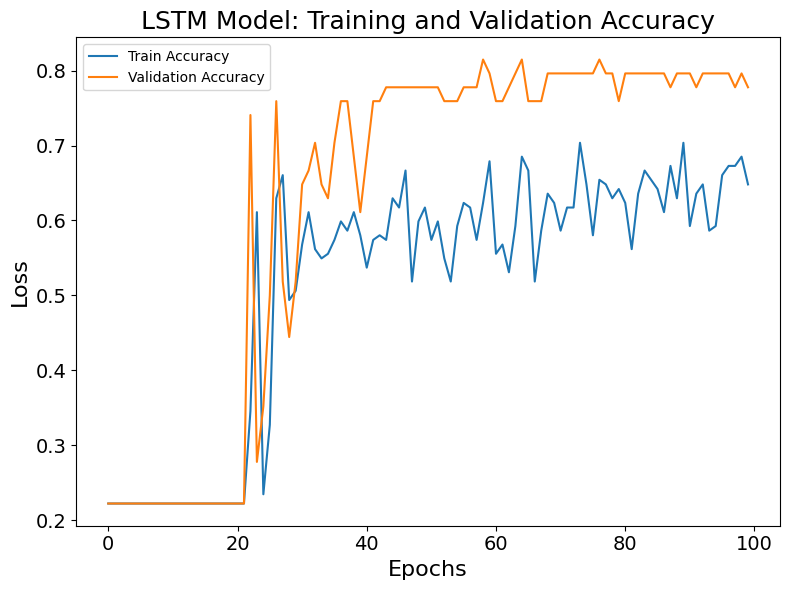

In [ ]:
# Plotting loss train dan validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('LSTM Model: Training and Validation Accuracy', fontsize=18)  # Memperbesar teks judul
plt.xlabel('Epochs', fontsize=16)  # Memperbesar teks sumbu x
plt.ylabel('Loss', fontsize=16)  # Memperbesar teks sumbu y
plt.xticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu x
plt.yticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu y
plt.legend()
plt.tight_layout()

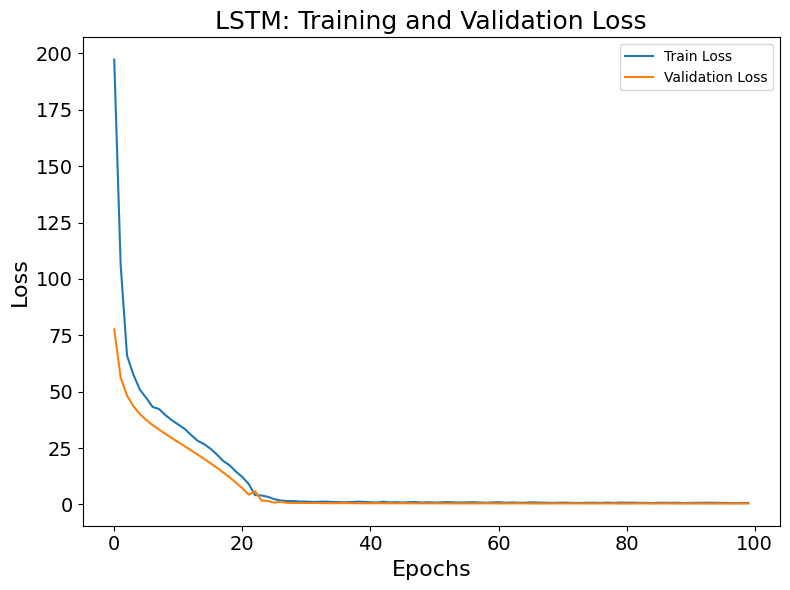

In [ ]:
# Plotting loss train dan validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('LSTM: Training and Validation Loss', fontsize=18)  # Memperbesar teks judul
plt.xlabel('Epochs', fontsize=16)  # Memperbesar teks sumbu x
plt.ylabel('Loss', fontsize=16)  # Memperbesar teks sumbu y
plt.xticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu x
plt.yticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu y
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

# Prediksi probabilitas
y_pred_prob = model3.predict(testing_padded)

# Mengubah probabilitas menjadi kelas biner
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Tampilkan classification report
print(classification_report(y_test, y_pred_binary))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        12
           1       0.79      0.98      0.87        42

    accuracy                           0.78        54
   macro avg       0.64      0.53      0.51        54
weighted avg       0.72      0.78      0.71        54



In [ ]:
from sklearn.metrics import classification_report

# Prediksi probabilitas
y_pred_prob = model3.predict(testing_padded)

# Mengubah probabilitas menjadi kelas biner
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Generate classification report sebagai dictionary
report = classification_report(y_test, y_pred_binary, output_dict=True)

# Ambil nilai weighted F1-score
weighted_f1 = report["weighted avg"]["f1-score"]

# Cetak classification report dan weighted F1-score
print(classification_report(y_test, y_pred_binary))
print(f"Weighted F1-score: {weighted_f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        12
           1       0.79      0.98      0.87        42

    accuracy                           0.78        54
   macro avg       0.64      0.53      0.51        54
weighted avg       0.72      0.78      0.71        54

Weighted F1-score: 0.7102
